# Example 12

In this example we do not have the data.    
Then, we use the data from `(Sharpe, 2021) - Business statistics`, Table 19.1

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate
import scipy.stats as sc_stats
import itertools

from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations



### Read `ods` to `DataFrame`

In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get multiple regression coefficients

In [5]:
def get_multiple_regress_coeff(df, n_vars=2):
  
  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = LinearRegression().fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]


    regress = LinearRegression().fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [6]:
def get_minitab_out(df, n_vars=2, new_column=None, withVIF=False):
  """
  new_column (dict) : a dictionary mapping to rename df header
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]

  # -- compute cofactor matrix 
  X_arr = np.ones_like(data_struct)
  X_arr[:,1:] = data_struct[:,1:]
  cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix

  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()
  s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  dof = num_of_samples - n_vars - 1;          # degrees of freedom
  for i in range(1+n_vars):
    SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
    t_scores[i] = b_arr[i] / SE_coef[i]
    p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a surfifal function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  SST = ((data_struct[:, 0] - meanY)**2).sum()
  SSR = ((hat_Y - meanY)**2).sum()
  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)

  # -- create tabular form for correlation 
  data = []
  for i in range(n_vars):
    data_row = [new_column[i+1]] + \
      [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
    #print(data_row)
    #print([type(data_row_i) for data_row_i in data_row])
    data.append(data_row)

  table_corr = tabulate.tabulate(data, tablefmt='html', 
    headers=[""] + new_column[:n_vars], 
    floatfmt=["None"] + [".3f"]*(n_vars))

  print(f"Correlations: {', '.join(new_column)}")
  display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  display(table_predictor)
  print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  return {"regress": regress, "corr_matrix": corr_matrix, 
    "R_sq": R_sq}


## Load the data

In [150]:
filename = "sharpe-2021-19-table-01-roller-coaster.ods"

df = read_ods(filename)

df

,Name,Park,Track,Speed,Height,Drop,Length,Duration,Inversions
0,Top Thrill Dragster,Cedar Point,Steel,120.0,420.0,400.0,2800.0,NaN,0
1,Superman The Escap,Six Flags Magic Mountain,Steel,100.0,415.0,328.1,1235.0,NaN,0
2,Millennium Force,Cedar Point,Steel,93.0,310.0,300.0,6595.0,165.0,0
3,Goliath,Six Flags Magic Mountain,Steel,85.0,235.0,255.0,4500.0,180.0,0
4,Titan,Six Flags Over Texas,Steel,85.0,245.0,255.0,5312.0,210.0,0
...,...,...,...,...,...,...,...,...,...
236,Thunderbird,Holiday World,Steel,60.0,140.0,NaN,3035.0,78.0,1
237,Twisted Colossus,Six Flags Magic Mountain,Steel,57.0,121.0,128.0,4990.0,220.0,1
238,Velikoluksky Miasokombinat,Wonder Island,Steel,62.1,124.7,NaN,3464.6,150.0,1
239,Wicked Cyclone,Six Flags New England,Steel,55.0,109.0,NaN,3320.0,NaN,1


In [151]:
df_select = df[["Speed", "Height", "Drop"]]
df_select = df_select.dropna()
df_select = df_select.reset_index(drop=True)

num_of_samples = 118     # (Sharpe, 2021) Table 19.6
df_select = df_select.iloc[:num_of_samples]
df_select

,Speed,Height,Drop
0,120.0,420.0,400.0
1,100.0,415.0,328.1
2,93.0,310.0,300.0
3,85.0,235.0,255.0
4,85.0,245.0,255.0
...,...,...,...
113,51.0,88.0,84.0
114,95.0,325.0,320.0
115,78.9,239.5,219.8
116,40.0,63.0,58.0


## Calculate Minitab output

In [67]:
df_minitab = df_select.copy()
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab


header: ['Speed', 'Height', 'Drop']


,Y,X_1,X_2
0,120.0,420.0,400.0
1,100.0,415.0,328.1
2,93.0,310.0,300.0
3,85.0,235.0,255.0
4,85.0,245.0,255.0
...,...,...,...
113,51.0,88.0,84.0
114,95.0,325.0,320.0
115,78.9,239.5,219.8
116,40.0,63.0,58.0


In [10]:
column_name = ["Speed", "Height", "Drop"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False)


Correlations: Speed, Height, Drop


,Speed,Height
Height,0.902,
Drop,0.944,0.929


Regression Analysis: Speed versus Height, Drop
The regression equation is
Speed = 34.591 + 0.037 Height + 0.163 Drop


Predictor,Coef,SE Coef,t-score,p-value
Constant,34.5913,1.0535,32.84,0.0000
Height,0.0372,0.0164,2.27,0.0253
Drop,0.1632,0.0171,9.52,0.0000


s_yxs = 4.7461   R_sq = 89.6%   R-sq(adj) = 89.4%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,2,22325.793,11162.897,495.578,0.0000
Residual error,115,2590.375,22.525,,
Total,117,24916.168,,,


## Plot of the fitted regression plane

In [12]:
df_regress = df_minitab.copy()
regress = out_dict["regress"]

x_min = df_regress['X_1'].min()
x_max = df_regress['X_1'].max()
x_data = np.linspace(0, x_max, 10)

y_min = df_regress['X_2'].min()
y_max = df_regress['X_2'].max()
y_data = np.linspace(0, y_max, 10)

z_data = regress.intercept_ + regress.coef_[0]*x_data.reshape((-1, 1)) \
  + regress.coef_[1]*y_data


In [105]:
z_color = np.zeros_like(z_data)
x_scatter_data = df_regress['X_1'].to_numpy()
y_scatter_data = df_regress['X_2'].to_numpy()
z_scatter_data = df_regress['Y'].to_numpy()

fig = go.Figure(data=[
  go.Surface(z=z_data.T, x=x_data, y=y_data, 
    colorscale="Blues", surfacecolor=z_color,
    showscale=False, opacity=0.7),
  go.Scatter3d(x=x_scatter_data, y=y_scatter_data, z=z_scatter_data, 
    mode="markers", marker_size=4)])

#go.Figure(data=[go.Scatter3d(x=df_regress['X_1'], y=df_regress['X_2'], 
#  z=df_regress['Y'], mode="markers")])

theta = [-70, 230, 85]
theta = np.deg2rad(theta)
a = 3.
camera = {
  'center': {'x': 0, 'y': -0.2, 'z': -0.2},
  'eye': {'x': a*np.cos(theta[0]), 'y': a*np.cos(theta[1]), 'z': a*np.cos(theta[2])}}

fig.update_layout(
  title="Fitted regression plane", autosize=True,
  width=500, height=500,
  margin={'l':35, 'r': 30, 'b':15, 't':50,},
  scene={
    "xaxis_title": "Height",
    "yaxis_title": "Drop",
    "zaxis_title": "Speed"},
  scene_camera=camera)


fig.show()


## standardized residual

### Leverage for multiple regression

Leverage for predictors in multiple regressions can be calculated 
by the following formula

$$
  h_{ii} = \vec{x}_i \left(\mathbf{X}^\mathsf{T} \, \mathbf{X}\right)^{-1} \vec{x}^\mathsf{T}_i
$$

$\mathbf{X}$ is a *design matrix* that has the following explicit form

$$
  \mathbf{X}
    = \begin{bmatrix}
        1      & X_{1,1} & \ldots & X_{1,k}  \\
        1      & X_{2,1} & \ldots & X_{2,k}  \\
        \vdots & \vdots  &        & \vdots   \\
        1      & X_{n,1} & \ldots & X_{n,k}
      \end{bmatrix}
$$

$n$ is the number of observation and $k$ the number of predictor variables.

$\vec{x}_i$ is $i$-th row of design matrix, 
$\vec{x}_i := [1, \,X_{i, 1}, \,\ldots, \,X_{i, k}]$

A rule of thumb suggests that $h_{ii}$ is large enough to merit checking if
$h_{ii} \geq 3(k+1) / n$

In [72]:
def get_leverage(df):
  columns = df.columns[1:]
  # print(columns)
  n_vars = len(columns)
  n_samples = len(df)

  X_arr = np.ones([n_samples, 1+n_vars])
  for i, predictor in enumerate(columns):
    X_arr[:, i+1] = df[predictor]

  cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix
  # print(cofactor_matrix)

  leverage_arr = np.zeros(n_samples)
  for i in range(n_samples):
    vec_x_i = X_arr[i, :]
    leverage_arr[i] = vec_x_i.dot(cofactor_matrix).dot(vec_x_i.transpose())

  return leverage_arr



In [69]:
df_stdzed_residual = df_select.copy()
from_column_names = df_stdzed_residual.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]

df_stdzed_residual = df_stdzed_residual.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

print(f"new header: {df_stdzed_residual.columns.to_list()}")

header: ['Speed', 'Height', 'Drop']
new header: ['Y', 'X_1', 'X_2']


In [98]:
leverage_arr = get_leverage(df_stdzed_residual)

### Histogram of leverage values

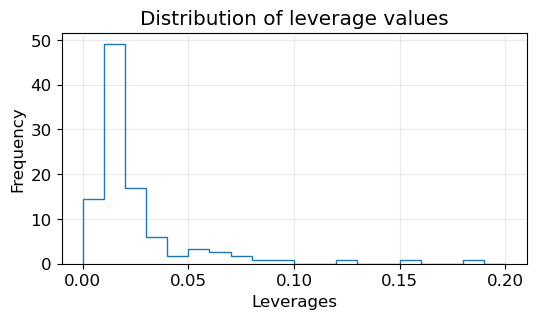

In [99]:
fig, ax = plt.subplots(figsize=(6, 3))

bins = np.arange(0, 0.2 + 0.01, 0.01) 
ax.hist(leverage_arr, histtype="step", bins=bins, density=True)


ax.set_xticks(np.arange(0, 0.2+0.05, 0.05))
ax.set_xlabel("Leverages")
ax.set_ylabel("Frequency")
ax.set_title(f"Distribution of leverage values")
ax.grid("on")

plt.show(fig)

### Plot of outliers based on large leverage values

In [85]:
n_vars = len(df_stdzed_residual.columns[1:])
n_samples = len(df_stdzed_residual)
l_bound_leverage = 3.*(n_vars + 1) / n_samples
is_outlier = leverage_arr > l_bound_leverage
# leverage_arr

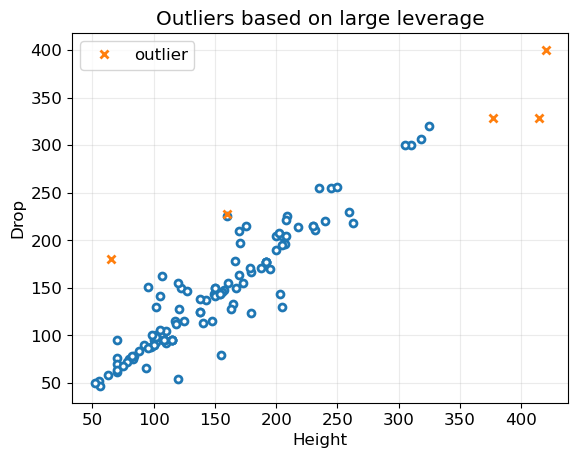

In [109]:
fig, ax = plt.subplots()

height_data = df_minitab["X_1"]
drop_data = df_minitab["X_2"]

normal_height_data = height_data[np.logical_not(is_outlier)]
normal_drop_data = drop_data[np.logical_not(is_outlier)]

outlier_height_data = height_data[is_outlier]
outlier_drop_data = drop_data[is_outlier]

ax.plot(normal_height_data, normal_drop_data,
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

ax.plot(outlier_height_data, outlier_drop_data,
  marker='x', markersize=6, linestyle="None",
  markeredgewidth=2, label="outlier")


ax.set_xlabel("Height")
ax.set_ylabel("Drop")
ax.set_title("Outliers based on large leverage")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

### standardized residual $e_i/s_{e_i}$

$$
  \frac{e_i}{s_{e_i}} = \frac{e_i}{s_{y\cdot x's} \sqrt{1 - h_{ii}}}
$$

A standardized residual is considering large (the response extreme) if
$$
  \left|\frac{e_i}{s_{e_i}} \right| > 2
$$

In [110]:
Y_data = df_regress['Y']
hat_Y_data = df_regress["hat_Y"]
e_arr = (hat_Y_data - Y_data).to_numpy()
n_samples = len(Y_data)
n_vars = len(df_stdzed_residual.columns)
sumSq_Y_hat_Y = ((Y_data - hat_Y_data)**2).sum()
s_yxs = np.sqrt(sumSq_Y_hat_Y/(n_samples - n_vars - 1))

stdzed_residual_arr = e_arr/(s_yxs * np.sqrt(1 - leverage_arr))

is_large_stdzed_residual = np.abs(stdzed_residual_arr) > 2.

### Plot outliers based on large standardized residual

In [ ]:
regress = out_dict["regress"]

x_min = df_regress['X_1'].min()
x_max = df_regress['X_1'].max()
x_data = np.linspace(0, x_max, 10)

y_min = df_regress['X_2'].min()
y_max = df_regress['X_2'].max()
y_data = np.linspace(0, y_max, 10)

z_data = regress.intercept_ + regress.coef_[0]*x_data.reshape((-1, 1)) \
  + regress.coef_[1]*y_data

In [138]:
z_color = np.zeros_like(z_data)
x_scatter_data = df_regress['X_1'].to_numpy()
y_scatter_data = df_regress['X_2'].to_numpy()
z_scatter_data = df_regress['Y'].to_numpy()

outlier_x_scatter_data = x_scatter_data[is_large_stdzed_residual]
outlier_y_scatter_data = y_scatter_data[is_large_stdzed_residual]
outlier_z_scatter_data = z_scatter_data[is_large_stdzed_residual]

normal_x_scatter_data = x_scatter_data[np.logical_not(is_large_stdzed_residual)]
normal_y_scatter_data = y_scatter_data[np.logical_not(is_large_stdzed_residual)]
normal_z_scatter_data = z_scatter_data[np.logical_not(is_large_stdzed_residual)]

fig = go.Figure(data=[
  go.Surface(z=z_data.T, x=x_data, y=y_data, 
    colorscale="Blues", surfacecolor=z_color,
    showscale=False, opacity=0.7),
  go.Scatter3d(
    x=normal_x_scatter_data, 
    y=normal_y_scatter_data, 
    z=normal_z_scatter_data, 
    marker={
      "color": ["rgb(255, 0, 0)" for i in range(len(normal_x_scatter_data))]},
    mode="markers", marker_size=4, name="normal"), 
  go.Scatter3d(
    x=outlier_x_scatter_data,
    y=outlier_y_scatter_data,
    z=outlier_z_scatter_data,
    marker={
      "color": ["rgb(0, 0, 0)" for i in range(len(outlier_x_scatter_data))],
      "symbol": "square"},
    mode="markers", marker_size=4, name="outlier")])


theta = [130, 80, 85]
theta = np.deg2rad(theta)
a = 3.
camera = {
  'center': {'x': 0, 'y': 0, 'z': -0.2},
  'eye': {'x': a*np.cos(theta[0]), 'y': a*np.cos(theta[1]), 'z': a*np.cos(theta[2])}}

fig.update_layout(
  title="Fitted regression plane", autosize=True,
  width=600, height=500,
  margin={'l':35, 'r': 30, 'b':15, 't':50,},
  scene={
    "xaxis_title": "Height",
    "yaxis_title": "Drop",
    "zaxis_title": "Speed"},
  scene_camera=camera)


fig.show()



### Unusual observation 

In [160]:
df_observation = df_select.copy()
df_observation["FitSpeed"] = df_regress["hat_Y"]
df_observation["Residual"] = df_regress["Y"] - df_regress["hat_Y"]
df_observation["StdzedResid"] = stdzed_residual_arr

# -- get unusua observation status
status_arr = []
for stat_leverage, stat_stdzed_resid in zip(is_outlier, is_large_stdzed_residual):
  status = '' 
  if stat_leverage:
    status += 'X' 

  if stat_stdzed_resid and status == 'X':
    status += ",R"
  if stat_stdzed_resid and status == '':
    status += 'R'

  status_arr.append(status)

df_observation["Observe"] = status_arr 

df_observation

,Speed,Height,Drop,FitSpeed,Residual,StdzedResid,Observe
0,120.0,420.0,400.0,115.497358,4.502642,-1.010991,X
1,100.0,415.0,328.1,103.577082,-3.577082,0.816484,X
2,93.0,310.0,300.0,95.084833,-2.084833,0.448806,
3,85.0,235.0,255.0,84.950534,0.049466,-0.010563,
4,85.0,245.0,255.0,85.322558,-0.322558,0.068729,
...,...,...,...,...,...,...,...
113,51.0,88.0,84.0,51.574137,-0.574137,0.121427,
114,95.0,325.0,320.0,98.906921,-3.906921,0.845905,
115,78.9,239.5,219.8,79.373215,-0.473215,0.100309,
116,40.0,63.0,58.0,46.400809,-6.400809,1.358719,


In [161]:
df_observation.iloc[is_outlier+is_large_stdzed_residual]

,Speed,Height,Drop,FitSpeed,Residual,StdzedResid,Observe
0,120.0,420.00,400.0,115.497358,4.502642,-1.010991,X
1,100.0,415.00,328.1,103.577082,-3.577082,0.816484,X
5,82.0,160.00,228.0,77.753881,4.246119,-0.929208,X
6,82.0,205.00,130.0,63.434141,18.565859,-4.028381,R
8,80.0,165.00,133.0,62.435651,17.564349,-3.715937,R
23,70.0,155.00,80.0,53.413891,16.586109,-3.609180,R
26,67.0,110.00,105.0,55.819844,11.180156,-2.359537,R
71,100.0,377.33,328.1,102.175666,-2.175666,0.479626,X
76,68.0,65.00,180.0,66.385925,1.614075,-0.374518,X
87,83.0,170.60,196.8,73.056307,9.943693,-2.111415,R
